## 02 Generating the sample space


## General Notebook Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import chaospy as cp
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from helper_functions import get_envelope, eval_polynomial, setup_plot

sns.set_theme(style="whitegrid", palette="bright")
bright_palette = sns.color_palette("bright")

In [3]:
# Constants for DataFrame column names
COLUMN_WIND_SPEED_AVG = "Wind speed (avg.) [m/s]"
COLUMN_TI_EST = "TI_est"
COLUMN_AIR_DENSITY_AVG = "Air Density [kg/m3]"
COLUMN_RELATIVE_WIND_DIRECTION_AVG = "Relative wind direction (wind shear) (avg.) [°]"

# Define file path and name
input_path = os.path.join(os.path.dirname(os.getcwd()), r"data\scada")
sample_path = os.path.join(os.path.dirname(os.getcwd()), r"data\samples")

filename = 'farmdata_2017-2022_refined.feather'
file_full_path = os.path.join(input_path, filename)

# Read the data
df = pd.read_feather(file_full_path)
df = df.loc[~df.is_Abnormal]

## Set up the envelopes for the distributions


In [4]:
# Constants for wind speed range
MIN_WIND_SPEED = 3  # Minimum wind speed in m/s
MAX_WIND_SPEED = 25  # Maximum wind speed in m/s

# Constants for the shape parameters of the beta distribution
# Higher alpha for more concentration near minimum speed
ALPHA = 1.02
# Lower beta for slower decrease towards maximum speed
BETA = 3

# Constants for the number of samples
NUM_SAMPLES = 1000000  # Number of wind speed samples to draw

# Generate wind speed samples based on a beta distribution
samples = np.random.beta(ALPHA, BETA, NUM_SAMPLES)
wind_speed_samples = MIN_WIND_SPEED + \
    samples * (MAX_WIND_SPEED - MIN_WIND_SPEED)

# Constants for the order of polynomial fit for turbulence intensity envelopes
TI_ORDER_UPPER = 3
TI_ORDER_LOWER = 2

# Calculate the upper and lower envelopes for turbulence intensity
lower_ti, upper_ti = get_envelope(
    df, COLUMN_TI_EST, order_upper=TI_ORDER_UPPER, order_lower=TI_ORDER_LOWER)

# Calculate the upper and lower envelopes for air density
lower_rho, upper_rho = get_envelope(df, COLUMN_AIR_DENSITY_AVG)

# Constant for the order of polynomial fit for yaw misalignment envelopes
YAW_ORDER = 18

# Calculate the upper and lower envelopes for relative wind direction
lower_yaw, upper_yaw = get_envelope(
    df, COLUMN_RELATIVE_WIND_DIRECTION_AVG, order_upper=YAW_ORDER, order_lower=YAW_ORDER)

## Plotting the Distributions


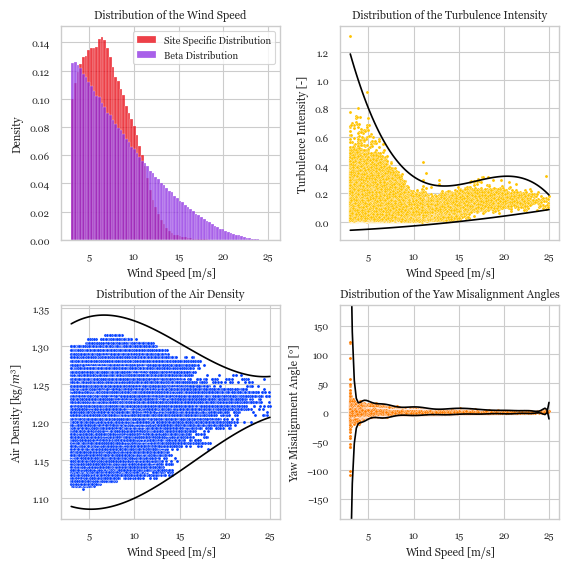

In [5]:
WIDTH, HEIGHT = setup_plot(1)
WIDTH, HEIGHT = WIDTH*.9, HEIGHT*.9
fig, axs = plt.subplots(2, 2, figsize=(WIDTH, HEIGHT))

# First subplot (top-left): Distribution of Wind Speed
sns.histplot(data=df, x=COLUMN_WIND_SPEED_AVG, binwidth=.3, color=bright_palette[3],
            stat="density", label="Site Specific Distribution", ax=axs[0, 0])
sns.histplot(wind_speed_samples, binwidth=.3,
            color=bright_palette[4], stat="density", label="Beta Distribution", ax=axs[0, 0])
axs[0, 0].legend()
axs[0, 0].set_title('Distribution of the Wind Speed')
axs[0, 0].set_xlabel('Wind Speed [m/s]')

# Second subplot (top-right): Distribution of Turbulence Intensity
sns.scatterplot(data=df, x=COLUMN_WIND_SPEED_AVG, y=COLUMN_TI_EST,
                s=5, color=bright_palette[-2], ax=axs[0, 1])
sample_x = np.linspace(df[COLUMN_WIND_SPEED_AVG].min(),
                    df[COLUMN_WIND_SPEED_AVG].max(), num=100)
sns.lineplot(x=sample_x, y=eval_polynomial(
    sample_x, upper_ti, order=3), color="black", ax=axs[0, 1])
sns.lineplot(x=sample_x, y=eval_polynomial(
    sample_x, lower_ti, order=2), color="black", ax=axs[0, 1])
axs[0, 1].set_title('Distribution of the Turbulence Intensity')
axs[0, 1].set_ylabel('Turbulence Intensity [-]')
axs[0, 1].set_xlabel('Wind Speed [m/s]')

# Third subplot (bottom-left): Distribution of Air Density
sns.scatterplot(data=df, x=COLUMN_WIND_SPEED_AVG, y=COLUMN_AIR_DENSITY_AVG, s=5,
                color=bright_palette[0], ax=axs[1, 0])
sns.lineplot(x=sample_x, y=lower_rho(sample_x), color="black", ax=axs[1, 0])
sns.lineplot(x=sample_x, y=upper_rho(sample_x), color="black", ax=axs[1, 0])
axs[1, 0].set_title('Distribution of the Air Density')
axs[1, 0].set_ylabel('Air Density [kg/$m^3$]')
axs[1, 0].set_xlabel('Wind Speed [m/s]')

# Fourth subplot (bottom-right): Distribution of Yaw Misalignment Angles
sns.scatterplot(data=df, x=COLUMN_WIND_SPEED_AVG, y=COLUMN_RELATIVE_WIND_DIRECTION_AVG, s=5,
                color=bright_palette[1], ax=axs[1, 1])
axs[1, 1].plot(sample_x, eval_polynomial(
    sample_x, lower_yaw, YAW_ORDER), color="black")
axs[1, 1].plot(sample_x, eval_polynomial(
    sample_x, upper_yaw, YAW_ORDER), color="black")
axs[1, 1].set_title('Distribution of the Yaw Misalignment Angles')
axs[1, 1].set_ylabel('Yaw Misalignment Angle [°]')
axs[1, 1].set_xlabel('Wind Speed [m/s]')
axs[1, 1].set_ylim(-185, 185)

plt.tight_layout()
plt.show()

## Sampling from the unitary Hypercube (4D)

In [6]:
# Define the Beta distribution for wind conditions
dist_wind = cp.Beta(ALPHA, BETA, MIN_WIND_SPEED, MAX_WIND_SPEED)

# Define uniform distributions for turbulence intensity, air density, and yaw misalignment
# The bounds are estimated using fitted polynomials evaluated at the wind speed distribution
dist_ti = cp.Uniform(eval_polynomial(dist_wind, lower_ti, TI_ORDER_LOWER),
                    eval_polynomial(dist_wind, upper_ti, TI_ORDER_UPPER))
dist_rho = cp.Uniform(eval_polynomial(dist_wind, lower_rho),
                    eval_polynomial(dist_wind, upper_rho))
dist_yaw = cp.Uniform(eval_polynomial(dist_wind, lower_yaw, YAW_ORDER),
                    eval_polynomial(dist_wind, upper_yaw, YAW_ORDER))

# Combine the distributions into a joint distribution
joint = cp.J(dist_wind, dist_ti, dist_rho, dist_yaw)

### Generating Training Samples
Here, the samples are drawn. Each needs to be checked for physical validity.

In [7]:
initial_count = 300

incremental_count = initial_count

valid_sobol_samples = np.empty((4, 0))

while valid_sobol_samples.shape[1] < initial_count:
    sobol_samples = joint.sample(incremental_count, rule="sobol").round(5)

    mask_ti = sobol_samples[1, :] <= 0
    mask_yaw = (sobol_samples[3, :] <= -180) | (sobol_samples[3, :] >= 180)

    mask_combined = mask_ti | mask_yaw
    valid_sobol_samples = sobol_samples[:, ~mask_combined]

    num_outofbound = np.sum(mask_combined)
    incremental_count = initial_count + num_outofbound

Per valid sample, we generate 30 replications with varying seeds for TurbSim. 

In [8]:
replications = 30
num_columns = initial_count
seeds_training = np.random.randint(-2147483648,
                                   2147483647, size=(1, replications * num_columns))
training_cases = np.tile(valid_sobol_samples, (1, replications))
training_cases = np.vstack((training_cases, seeds_training))

#### Plot the Training Samples

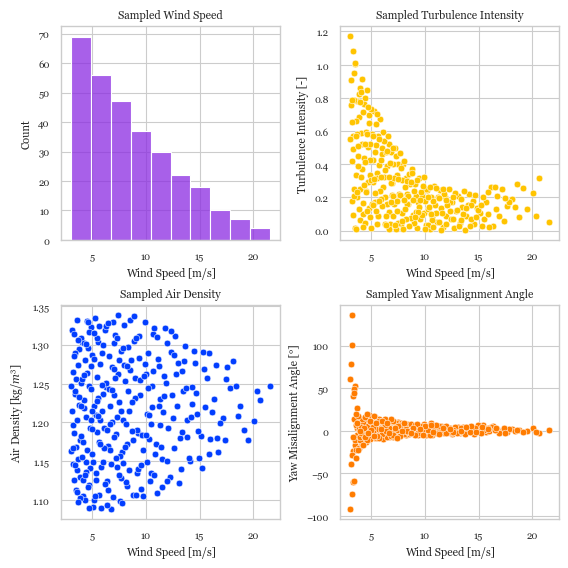

In [9]:
WIDTH, HEIGHT = setup_plot(1)
WIDTH, HEIGHT = WIDTH*.9, HEIGHT*.9

fig, axes = plt.subplots(2, 2, figsize=(WIDTH, HEIGHT))

sns.histplot(valid_sobol_samples[0], ax=axes[0, 0], color=bright_palette[4])
axes[0, 0].set_title(f"Sampled Wind Speed")
axes[0, 0].set_xlabel('Wind Speed [m/s]')

sns.scatterplot(
    x=valid_sobol_samples[0], y=valid_sobol_samples[1], ax=axes[0, 1], color=bright_palette[-2])
axes[0, 1].set_title(f"Sampled Turbulence Intensity")
axes[0, 1].set_ylabel('Turbulence Intensity [-]')
axes[0, 1].set_xlabel('Wind Speed [m/s]')


sns.scatterplot(
    x=valid_sobol_samples[0], y=valid_sobol_samples[2], ax=axes[1, 0], color=bright_palette[0])
axes[1, 0].set_title(f"Sampled Air Density")
axes[1, 0].set_ylabel('Air Density [kg/$m^3$]')
axes[1, 0].set_xlabel('Wind Speed [m/s]')


sns.scatterplot(
    x=valid_sobol_samples[0], y=valid_sobol_samples[3], ax=axes[1, 1], color=bright_palette[1])
axes[1, 1].set_title(f"Sampled Yaw Misalignment Angle")
axes[1, 1].set_ylabel('Yaw Misalignment Angle [°]')
axes[1, 1].set_xlabel('Wind Speed [m/s]')

plt.tight_layout()

### Generate Validation Samples
Now we draw a set of 30 validation samples at random. Same as above, each sample is realized with 30 different seeds combinations.

In [10]:
initial_test_count = 40
desired_test_samples = 30

valid_test_samples = np.empty((4, 0))

mc_samples = joint.sample(initial_test_count, rule="random").round(5)

mask_ti = mc_samples[1, :] <= 0
mask_yaw = (mc_samples[3, :] < -180) | (mc_samples[3, :] > 180)

mask_combined = mask_ti | mask_yaw
valid_test_samples = mc_samples[:, ~mask_combined]

if valid_test_samples.shape[1] >= desired_test_samples:
    selected_test_samples = valid_test_samples[:, np.random.choice(
        valid_test_samples.shape[1], desired_test_samples, replace=False)]
else:
    print("Not enough samples in the specified range.")

In [11]:
replications = 30
num_columns = desired_test_samples
seeds_test = np.random.randint(-2147483648,
                               2147483647, size=(1, replications * num_columns))
test_cases = np.tile(selected_test_samples, (1, replications))
test_cases = np.vstack((test_cases, seeds_test))

Finally, combine all samples into a single array. Based of this the casematrix.csv was generated (not shown here).

In [ ]:
full_cases = np.hstack((training_cases, test_cases))
with open(os.path.join(sample_path, 'sample_set.npy'), 'wb') as f:
    np.save(f, full_cases)